<a href="https://colab.research.google.com/github/spatank/Curiosity/blob/master/v8/C_plotting_and_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Curiosity_v8/')

Mounted at /content/drive


In [2]:
!ls # run !ls to verify location

build_Wiki_networks.ipynb      persistent_homology_KNOT.ipynb
C_plotting_and_stats.ipynb     persistent_homology_simulations.ipynb
C_plotting.ipynb	       persistent_homology_Wiki.ipynb
Figures			       PH_plotting_and_stats.ipynb
KNOT			       PH_plotting.ipynb
mech_plotting_and_stats.ipynb  Simulations
mech_plotting.ipynb	       Wiki


In [3]:
import glob
import scipy.io as sio
import numpy as np
from scipy import stats
from scipy import integrate
import random
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [4]:
import sys
!{sys.executable} -m pip install traces

import traces

def time_normalize_and_merge(timeseries_lst, make_1_1 = False):
    """
    Takes in a list of time series (of possibly different lengths) and
    subsamples them using traces so they all range from 0 and 1 and are defined
    on the same points.
    """
    n_series = len(timeseries_lst)
    timeseries_lst = [traces.TimeSeries(zip(*(np.linspace(0, 1, len(ts)), ts)))
                      for ts in timeseries_lst]
    timeseries_lst = traces.TimeSeries.merge(timeseries_lst)
    if make_1_1:
        timeseries_lst[1.0] = [1.0] * n_series
    X = list(zip(*timeseries_lst.items()))[0]  # x values
    Y = list(zip(*timeseries_lst.items()))[1]  # y values across all series
    return X, Y

def plot_curve(curves_lst, curve_label = 'none', curve_color = 'none', null = 'none'):
  """
  Accepts a list of curves and the identity of the null model used if the data 
  come from one; curve_label and curve_color arguments are used for plotting.
  Plots average curve with a standard deviation/error band. 
  """
  max_nodes = max([len(lst) for lst in curves_lst])
  curves_mat = np.empty([len(curves_lst), max_nodes])
  curves_mat[:] = np.nan
  for i, j in enumerate(curves_lst):
    curves_mat[i][0:len(j)] = j
  numels = np.count_nonzero(~np.isnan(curves_mat), axis = 0)
  mean = np.nanmean(curves_mat, axis = 0)[numels > 1]
  std = np.nanstd(curves_mat, axis = 0)[numels > 1]
  # mins = mean - std
  mins = mean - np.divide(std, np.sqrt(numels[numels > 1]))
  mins = np.maximum(0, mins)
  # maxes = mean + std
  maxes = mean + np.divide(std, np.sqrt(numels[numels > 1]))
  X = np.arange(len(numels[numels > 1]))

  plt.plot(X, mean, color = curve_color, label = curve_label,
            linewidth = 1)
  # plt.gca().set_aspect(1./plt.gca().get_data_ratio())
  plt.fill_between(X, mins, maxes, facecolor = curve_color, alpha = 0.2)
  return X, mean


def plot_curve_normalized_idx(curves_lst, curve_label = 'none', curve_color = 'none', null = 'none'):
  """
  Accepts a list of curves and the identity of the null model used if the data 
  come from one; curve_label and curve_color arguments are used for plotting.
  Plots average curve with a standard deviation/error band, and with the  
  horizontal axis normalized to be [0, 1].
  """
  
  X, Y = time_normalize_and_merge(curves_lst)
  mean = np.nanmean(Y, axis = 1)
  # mins = np.nanmean(Y, axis = 1) - np.nanstd(Y, axis = 1)
  mins = np.nanmean(Y, axis = 1) - np.nanstd(Y, axis = 1)/np.sqrt(len(curves_lst))
  mins = np.maximum(0, mins)
  # maxes = np.nanmean(Y, axis = 1) + np.nanstd(Y, axis = 1)
  maxes = np.nanmean(Y, axis = 1) + np.nanstd(Y, axis = 1)/np.sqrt(len(curves_lst))

  plt.plot(X, mean, color = curve_color, label = curve_label,
            linewidth = 1)
  # plt.gca().set_aspect(1./plt.gca().get_data_ratio())
  plt.fill_between(X, mins, maxes, facecolor = curve_color, alpha = 0.2)
  return X, mean

def permutation_testing(x_1, mean_1, x_2, mean_2):
  y_empirical = mean_1[~np.isnan(mean_1)]
  x_empirical = np.array(x_1)[~np.isnan(mean_1)]
  area_empirical = integrate.trapz(y_empirical, x_empirical) # empirical

  y_null = mean_2[~np.isnan(mean_2)]
  x_null = np.array(x_2)[~np.isnan(mean_2)]
  area_null = integrate.trapz(y_null, x_null) # null

  area_difference = np.abs(area_empirical - area_null)

  empirical_group_size = len(x_empirical)
  null_group_size = len(x_null)

  all_data = list(zip(mean_1, x_1)) + list(zip(mean_2, x_2))

  number_of_permutations = 1000
  counter = 0

  for i in range(number_of_permutations):
    random.shuffle(all_data) # shuffle the data
    new_empirical = sorted(all_data[:empirical_group_size], key = lambda x: x[1])
    new_null = sorted(all_data[empirical_group_size:], key = lambda x: x[1])

    unzip_new_empirical = list(zip(*new_empirical))
    y_empirical_new = unzip_new_empirical[0]
    x_empirical_new = unzip_new_empirical[1]
    area_empirical_new = integrate.trapz(y_empirical_new, x_empirical_new) # empirical new

    unzip_new_null = list(zip(*new_null))
    y_null_new = unzip_new_null[0]
    x_null_new = unzip_new_null[1]
    area_null_new = integrate.trapz(y_null_new, x_null_new) # null new

    area_difference_permuted = np.abs(area_empirical_new - area_null_new)

    if area_difference_permuted > area_difference:
      counter += 1

  p_value = counter/number_of_permutations
  return p_value

  Created wheel for infinity: filename=infinity-1.5-py3-none-any.whl size=3095 sha256=690fe1d388535a83cb34aadf15e021e091a1ad4983a9ccb6c3e615b5bff1ce02
  Stored in directory: /root/.cache/pip/wheels/ee/2c/f4/26985d995b1d5930ab73914f76ffccd54b1af31c2e68b507bc
Successfully built infinity


# KNOT

In [5]:
base_path = '/content/drive/My Drive/Curiosity_v8/KNOT/Processed/C/'

In [6]:
files = glob.glob(base_path + '*.mat')

   ## All Participants

In [7]:
files = glob.glob(base_path + '*.mat')

all_num_nodes = []
all_clust_coef = []
all_clust_coef_edge_rewired = []
all_clust_coef_latticized = []
all_C = []
all_C_edge_rewired = []
all_C_latticized = []
all_C_norm = []
all_C_norm_edge_rewired = []
all_C_norm_latticized = []
all_entropy = []
all_entropy_edge_rewired = []
all_entropy_latticized = []

for idx, C_file in enumerate(files):
  data_dict = sio.loadmat(C_file)
  num_nodes = data_dict['n']
  all_num_nodes.append(num_nodes)

  all_clust_coef.append(np.squeeze(data_dict['clust_coef']))
  clust_coef_edge_rewired = data_dict['clust_coef_edge_rewired']
  all_clust_coef_edge_rewired.append(list(np.nanmean(clust_coef_edge_rewired, axis = 0)))
  clust_coef_latticized = data_dict['clust_coef_latticized']
  all_clust_coef_latticized.append(list(np.nanmean(clust_coef_latticized, axis = 0)))

  all_C.append(np.squeeze(data_dict['C']))
  C_edge_rewired = data_dict['C_edge_rewired']
  all_C_edge_rewired.append(list(np.nanmean(C_edge_rewired, axis = 0)))
  C_latticized = data_dict['C_latticized']
  all_C_latticized.append(list(np.nanmean(C_latticized, axis = 0)))

  all_C_norm.append(np.squeeze(data_dict['C_norm']))
  C_norm_edge_rewired = data_dict['C_norm_edge_rewired']
  all_C_norm_edge_rewired.append(list(np.nanmean(C_norm_edge_rewired, axis = 0)))
  C_norm_latticized = data_dict['C_norm_latticized']
  all_C_norm_latticized.append(list(np.nanmean(C_norm_latticized, axis = 0)))

  all_entropy.append(np.squeeze(data_dict['entropy']))
  entropy_edge_rewired = data_dict['entropy_edge_rewired']
  all_entropy_edge_rewired.append(list(np.nanmean(entropy_edge_rewired, axis = 0)))
  entropy_latticized = data_dict['entropy_latticized']
  all_entropy_latticized.append(list(np.nanmean(entropy_latticized, axis = 0)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


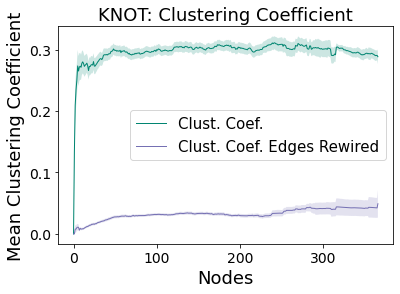

In [8]:
x_1, mean_1 = plot_curve(all_clust_coef, curve_label = 'Clust. Coef.', curve_color = '#018571')
x_2, mean_2 = plot_curve(all_clust_coef_edge_rewired, curve_label = 'Clust. Coef. Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_clust_coef_latticized, curve_label = 'Clust. Coef. Latticized', curve_color = '#d95f02')
plt.title('KNOT: Clustering Coefficient', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Mean Clustering Coefficient', fontsize = 18)
plt.legend(loc = 'center right', fontsize = 15)
plt.savefig('Figures/C/all_KNOT_clust_coef.pdf', transparent = True, bbox_inches = 'tight')

In [9]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.997275204359673 5.5177894834267655e-217


In [10]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


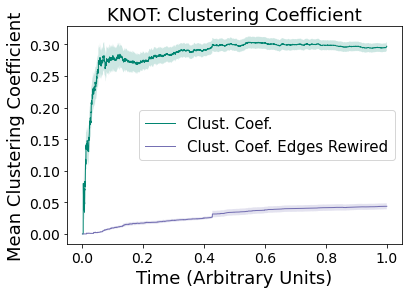

In [11]:
x_1, mean_1 = plot_curve_normalized_idx(all_clust_coef, curve_label = 'Clust. Coef.', curve_color = '#018571')
x_2, mean_2 = plot_curve_normalized_idx(all_clust_coef_edge_rewired, curve_label = 'Clust. Coef. Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_clust_coef_latticized, curve_label = 'Clust. Coef. Latticized', curve_color = '#d95f02')
plt.title('KNOT: Clustering Coefficient', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('Mean Clustering Coefficient', fontsize = 18)
plt.legend(loc = 'center right', fontsize = 15)
plt.savefig('Figures/C/all_KNOT_clust_coef_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [12]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.9948714062368755 0.0


In [13]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


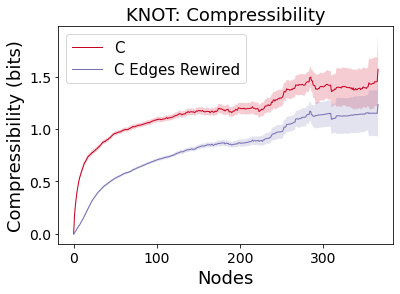

In [14]:
x_1, mean_1 = plot_curve(all_C, curve_label = 'C', curve_color = '#ca0020')
x_2, mean_2 = plot_curve(all_C_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_C_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('KNOT: Compressibility', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility (bits)', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/C/all_KNOT_C.pdf', transparent = True, bbox_inches = 'tight')

In [15]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.6212534059945504 1.4290437599511086e-66


In [16]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


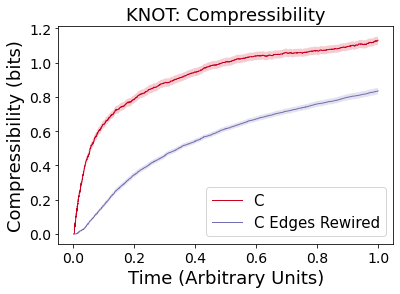

In [17]:
x_1, mean_1 = plot_curve_normalized_idx(all_C, curve_label = 'C', curve_color = '#ca0020')
x_2, mean_2 = plot_curve_normalized_idx(all_C_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_C_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('KNOT: Compressibility', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('Compressibility (bits)', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/C/all_KNOT_C_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [18]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.783563352094366 0.0


In [19]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


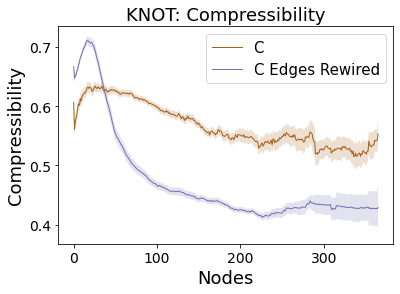

In [20]:
x_1, mean_1 = plot_curve(all_C_norm, curve_label = 'C', curve_color = '#a6611a')
x_2, mean_2 = plot_curve(all_C_norm_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_C_norm_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('KNOT: Compressibility', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility', fontsize = 18)
plt.legend(loc = 'upper right', fontsize = 15)
plt.savefig('Figures/C/all_KNOT_C_norm.pdf', transparent = True, bbox_inches = 'tight')

In [21]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.8224043715846995 3.036919732280701e-125


In [22]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


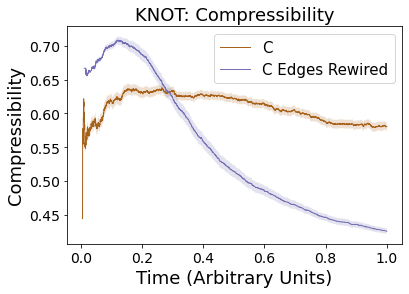

In [23]:
x_1, mean_1 = plot_curve_normalized_idx(all_C_norm, curve_label = 'C', curve_color = '#a6611a')
x_2, mean_2 = plot_curve_normalized_idx(all_C_norm_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_C_norm_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('KNOT: Compressibility', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('Compressibility', fontsize = 18)
plt.legend(loc = 'upper right', fontsize = 15)
plt.savefig('Figures/C/all_KNOT_C_norm_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [24]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.6331696793792891 0.0


In [25]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


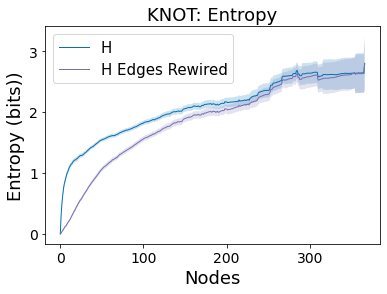

In [26]:
x_1, mean_1 = plot_curve(all_entropy, curve_label = 'H', curve_color = '#0571b0')
x_2, mean_2 = plot_curve(all_entropy_edge_rewired, curve_label = 'H Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_entropy_latticized, curve_label = 'H Latticized', curve_color = '#d95f02')
plt.title('KNOT: Entropy', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Entropy (bits))', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/C/all_KNOT_entropy.pdf', transparent = True, bbox_inches = 'tight')

In [27]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.15803814713896458 0.00020367749753413895


In [28]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


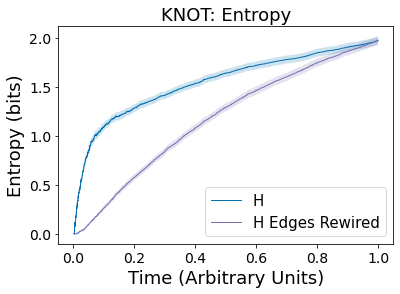

In [29]:
x_1, mean_1 = plot_curve_normalized_idx(all_entropy, curve_label = 'H', curve_color = '#0571b0')
x_2, mean_2 = plot_curve_normalized_idx(all_entropy_edge_rewired, curve_label = 'H Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_entropy_latticized, curve_label = 'H Latticized', curve_color = '#d95f02')
plt.title('KNOT: Entropy', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('Entropy (bits)', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/C/all_KNOT_entropy_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [30]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.3109307584222637 0.0


In [31]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


## One Participant

In [32]:
subj_ID = 106

data_dict = sio.loadmat(base_path + 'subj_' + str(subj_ID) + '_C.mat')

num_nodes = data_dict['n']

clust_coef = np.squeeze(data_dict['clust_coef'])
clust_coef_edge_rewired = data_dict['clust_coef_edge_rewired']
clust_coef_latticized = data_dict['clust_coef_latticized']

C = np.squeeze(data_dict['C'])
C_edge_rewired = data_dict['C_edge_rewired']
C_latticized = data_dict['C_latticized']

C_norm = np.squeeze(data_dict['C_norm'])
C_norm_edge_rewired = data_dict['C_norm_edge_rewired']
C_norm_latticized = data_dict['C_norm_latticized']

entropy = np.squeeze(data_dict['entropy'])
entropy_edge_rewired = data_dict['entropy_edge_rewired']
entropy_latticized = data_dict['entropy_latticized']

X = np.arange(num_nodes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


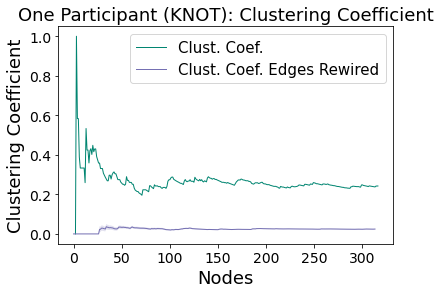

In [33]:
plt.plot(X, clust_coef, color = '#018571', label = 'Clust. Coef.', linewidth = 1)
x_1, mean_1 = plot_curve(clust_coef_edge_rewired, curve_label = 'Clust. Coef. Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(clust_coef_latticized, curve_label = 'Clust. Coef. Latticized', curve_color = '#d95f02')
plt.title('One Participant (KNOT): Clustering Coefficient', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Clustering Coefficient', fontsize = 18)
plt.legend(loc = 'upper right', fontsize = 15)

In [34]:
ks, p_ks = stats.ks_2samp(clust_coef, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.9968454258675079 1.4432899320127035e-15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


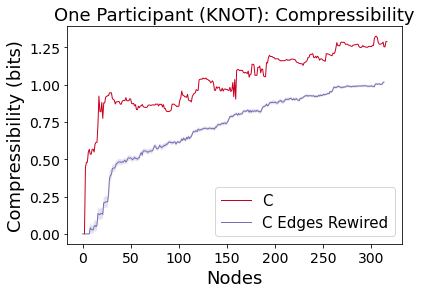

In [35]:
plt.plot(X, C, color = '#ca0020', label = 'C', linewidth = 1)
x_1, mean_1 = x_1, mean_1 = plot_curve(C_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(C_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('One Participant (KNOT): Compressibility', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility (bits)', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 15)

In [36]:
ks, p_ks = stats.ks_2samp(C, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.5519901946995117 1.4432899320127035e-15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


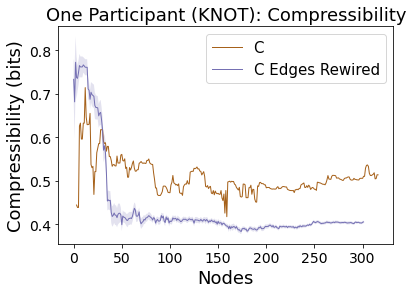

In [37]:
plt.plot(X, C_norm, color = '#a6611a', label = 'C', linewidth = 1)
x_1, mean_1 = plot_curve(C_norm_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(C_norm_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('One Participant (KNOT): Compressibility', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility (bits)', fontsize = 18)
plt.legend(loc = 'upper right', fontsize = 15)

In [38]:
ks, p_ks = stats.ks_2samp(C_norm, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.8645517788873337 7.802000990238451e-101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


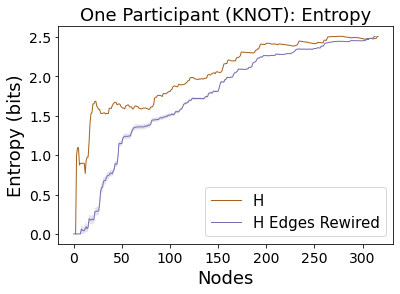

In [39]:
plt.plot(X, entropy, color = '#a6611a', label = 'H', linewidth = 1)
x_1, mean_1 = plot_curve(entropy_edge_rewired, curve_label = 'H Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(entropy_latticized, curve_label = 'H Latticized', curve_color = '#d95f02')
plt.title('One Participant (KNOT): Entropy', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Entropy (bits)', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 15)

In [40]:
ks, p_ks = stats.ks_2samp(entropy, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.2839217183387249 9.723666316574509e-12


# Wikipedia Networks

In [41]:
base_path = '/content/drive/My Drive/Curiosity_v8/Wiki/Processed/C/'

In [42]:
files = glob.glob(base_path + '*.mat')

## All Topics

In [43]:
all_num_nodes = []
all_clust_coef = []
all_clust_coef_edge_rewired = []
all_clust_coef_latticized = []
all_C = []
all_C_edge_rewired = []
all_C_latticized = []
all_C_norm = []
all_C_norm_edge_rewired = []
all_C_norm_latticized = []
all_entropy = []
all_entropy_edge_rewired = []
all_entropy_latticized = []

for idx, C_file in enumerate(files):
  data_dict = sio.loadmat(C_file)
  num_nodes = data_dict['n']
  all_num_nodes.append(num_nodes)

  all_clust_coef.append(np.squeeze(data_dict['clust_coef']))
  clust_coef_edge_rewired = data_dict['clust_coef_edge_rewired']
  all_clust_coef_edge_rewired.append(list(np.nanmean(clust_coef_edge_rewired, axis = 0)))
  clust_coef_latticized = data_dict['clust_coef_latticized']
  all_clust_coef_latticized.append(list(np.nanmean(clust_coef_latticized, axis = 0)))

  all_C.append(np.squeeze(data_dict['C']))
  C_edge_rewired = data_dict['C_edge_rewired']
  all_C_edge_rewired.append(list(np.nanmean(C_edge_rewired, axis = 0)))
  C_latticized = data_dict['C_latticized']
  all_C_latticized.append(list(np.nanmean(C_latticized, axis = 0)))

  all_C_norm.append(np.squeeze(data_dict['C_norm']))
  C_norm_edge_rewired = data_dict['C_norm_edge_rewired']
  all_C_norm_edge_rewired.append(list(np.nanmean(C_norm_edge_rewired, axis = 0)))
  C_norm_latticized = data_dict['C_norm_latticized']
  all_C_norm_latticized.append(list(np.nanmean(C_norm_latticized, axis = 0)))

  all_entropy.append(np.squeeze(data_dict['entropy']))
  entropy_edge_rewired = data_dict['entropy_edge_rewired']
  all_entropy_edge_rewired.append(list(np.nanmean(entropy_edge_rewired, axis = 0)))
  entropy_latticized = data_dict['entropy_latticized']
  all_entropy_latticized.append(list(np.nanmean(entropy_latticized, axis = 0)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


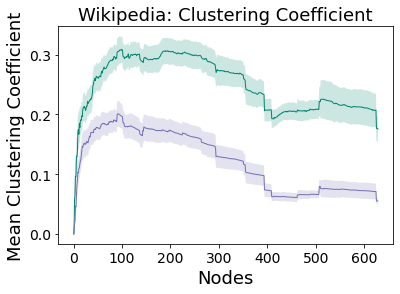

In [44]:
x_1, mean_1 = plot_curve(all_clust_coef, curve_label = 'Clust. Coef.', curve_color = '#018571')
x_2, mean_2 = plot_curve(all_clust_coef_edge_rewired, curve_label = 'Clust. Coef. Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_clust_coef_latticized, curve_label = 'Clust. Coef. Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: Clustering Coefficient', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Mean Clustering Coefficient', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/C/all_Wiki_clust_coef.pdf', transparent = True, bbox_inches = 'tight')

In [45]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.9491255961844197 7.08290235e-314


In [46]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


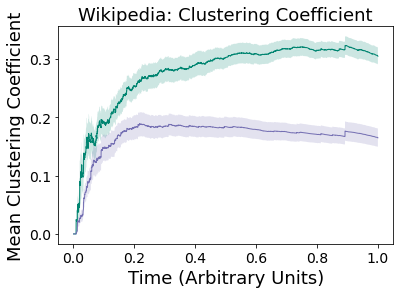

In [47]:
x_1, mean_1 = plot_curve_normalized_idx(all_clust_coef, curve_label = 'Clust. Coef.', curve_color = '#018571')
x_2, mean_2 = plot_curve_normalized_idx(all_clust_coef_edge_rewired, curve_label = 'Clust. Coef. Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_clust_coef_latticized, curve_label = 'Clust. Coef. Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: Clustering Coefficient', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('Mean Clustering Coefficient', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/C/all_Wiki_clust_coef_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [48]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.9386441161254299 1.0


In [49]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


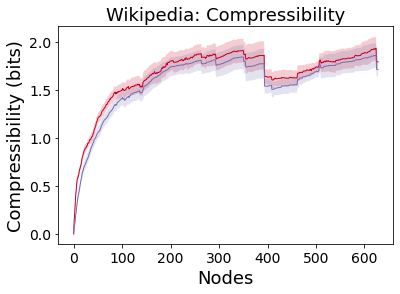

In [50]:
x_1, mean_1 = plot_curve(all_C, curve_label = 'C', curve_color = '#ca0020')
x_2, mean_2 = plot_curve(all_C_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_C_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: Compressibility', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility (bits)', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/C/all_Wiki_C.pdf', transparent = True, bbox_inches = 'tight')

In [51]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.29093799682034976 7.242588263864635e-24


In [52]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


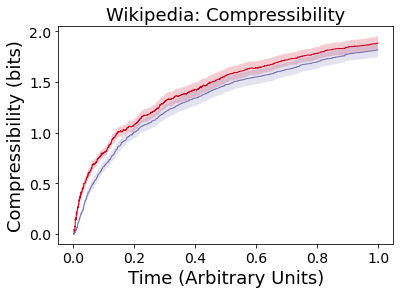

In [53]:
x_1, mean_1 = plot_curve_normalized_idx(all_C, curve_label = 'C', curve_color = '#ca0020')
x_2, mean_2 = plot_curve_normalized_idx(all_C_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_C_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: Compressibility', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('Compressibility (bits)', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/C/all_Wiki_C_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [54]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.169092478736163 1.0


In [55]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


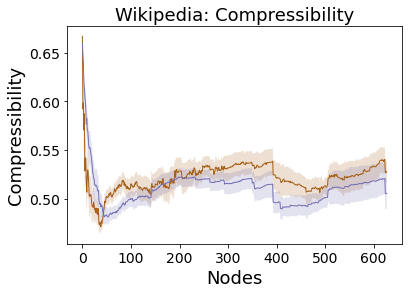

In [56]:
x_1, mean_1 = plot_curve(all_C_norm, curve_label = 'C', curve_color = '#a6611a')
x_2, mean_2 = plot_curve(all_C_norm_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_C_norm_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: Compressibility', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility', fontsize = 18)
# plt.legend(loc = 'upper right', fontsize = 15)
plt.savefig('Figures/C/all_Wiki_C_norm.pdf', transparent = True, bbox_inches = 'tight')

In [57]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.46178343949044587 8.452111275586585e-61


In [58]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


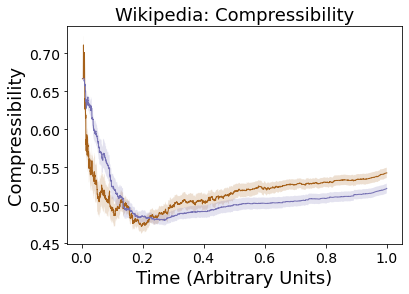

In [59]:
x_1, mean_1 = plot_curve_normalized_idx(all_C_norm, curve_label = 'C', curve_color = '#a6611a')
x_2, mean_2 = plot_curve_normalized_idx(all_C_norm_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_C_norm_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: Compressibility', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('Compressibility', fontsize = 18)
# plt.legend(loc = 'upper right', fontsize = 15)
plt.savefig('Figures/C/all_Wiki_C_norm_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [60]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.4222227787071218 1.0


In [61]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


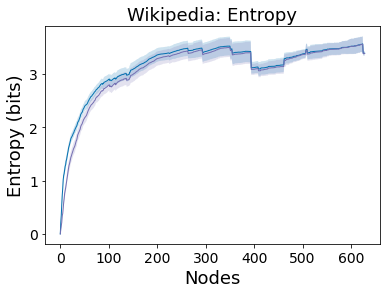

In [62]:
x_1, mean_1 = plot_curve(all_entropy, curve_label = 'H', curve_color = '#0571b0')
x_2, mean_2 = plot_curve(all_entropy_edge_rewired, curve_label = 'H Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_entropy_latticized, curve_label = 'H Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: Entropy', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Entropy (bits)', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/C/all_Wiki_entropy.pdf', transparent = True, bbox_inches = 'tight')

In [63]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.14149443561208266 6.575819563176944e-06


In [64]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


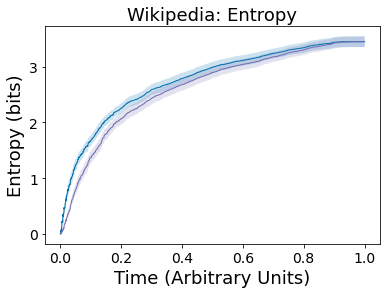

In [65]:
x_1, mean_1 = plot_curve_normalized_idx(all_entropy, curve_label = 'H', curve_color = '#0571b0')
x_2, mean_2 = plot_curve_normalized_idx(all_entropy_edge_rewired, curve_label = 'H Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_entropy_latticized, curve_label = 'H Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: Entropy', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('Entropy (bits)', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/C/all_Wiki_entropy_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [66]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.08513268943105591 1.0


In [67]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


## One Topic

In [68]:
topic_ID = 'software_engineering'

data_dict = sio.loadmat(base_path + topic_ID + '_C.mat')

num_nodes = data_dict['n']

clust_coef = np.squeeze(data_dict['clust_coef'])
clust_coef_edge_rewired = data_dict['clust_coef_edge_rewired']
clust_coef_latticized = data_dict['clust_coef_latticized']

C = np.squeeze(data_dict['C'])
C_edge_rewired = data_dict['C_edge_rewired']
C_latticized = data_dict['C_latticized']

C_norm = np.squeeze(data_dict['C_norm'])
C_norm_edge_rewired = data_dict['C_norm_edge_rewired']
C_norm_latticized = data_dict['C_norm_latticized']

entropy = np.squeeze(data_dict['entropy'])
entropy_edge_rewired = data_dict['entropy_edge_rewired']
entropy_latticized = data_dict['entropy_latticized']

X = np.arange(num_nodes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0, 0.5, 'Clustering Coefficient')

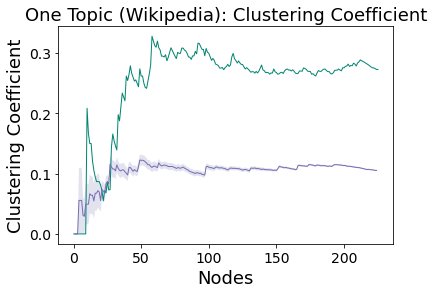

In [69]:
plt.plot(X, clust_coef, color = '#018571', label = 'Clust. Coef.', linewidth = 1)
x_1, mean_1 = plot_curve(clust_coef_edge_rewired, curve_label = 'Clust. Coef. Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(clust_coef_latticized, curve_label = 'Clust. Coef. Latticized', curve_color = '#d95f02')
plt.title('One Topic (Wikipedia): Clustering Coefficient', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Clustering Coefficient', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)

In [70]:
ks, p_ks = stats.ks_2samp(clust_coef, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.8982300884955752 1.9366596988717468e-79


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0, 0.5, 'Compressibility (bits)')

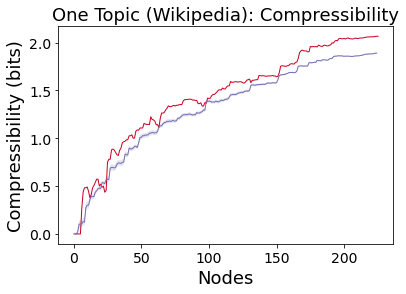

In [71]:
plt.plot(X, C, color = '#ca0020', label = 'C', linewidth = 1)
x_1, mean_1 = plot_curve(C_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(C_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('One Topic (Wikipedia): Compressibility', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility (bits)', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)

In [72]:
ks, p_ks = stats.ks_2samp(C, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.26548672566371684 1.5179698320544333e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0, 0.5, 'Compressibility')

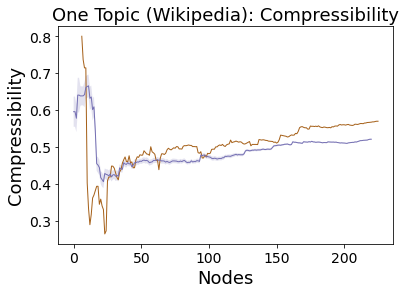

In [73]:
plt.plot(X, C_norm, color = '#a6611a', label = 'C', linewidth = 1)
x_1, mean_1 = plot_curve(C_norm_edge_rewired, curve_label = 'C Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(C_norm_latticized, curve_label = 'C Latticized', curve_color = '#d95f02')
plt.title('One Topic (Wikipedia): Compressibility', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility', fontsize = 18)
# plt.legend(loc = 'upper right', fontsize = 15)

In [74]:
ks, p_ks = stats.ks_2samp(C_norm, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.31135626476594724 4.2312287007462146e-10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0, 0.5, 'Entropy (bits)')

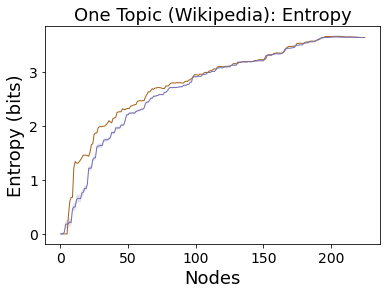

In [75]:
plt.plot(X, entropy, color = '#a6611a', label = 'H', linewidth = 1)
x_1, mean_1 = plot_curve(entropy_edge_rewired, curve_label = 'H Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(entropy_latticized, curve_label = 'H Latticized', curve_color = '#d95f02')
plt.title('One Topic (Wikipedia): Entropy', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Entropy (bits)', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)

In [76]:
ks, p_ks = stats.ks_2samp(entropy, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.08053097345132744 0.43214017133010485


# Simulated Networks

In [77]:
data_path = '/content/drive/My Drive/Curiosity_v8/Simulations/simulated_nets_C.mat'
data_dict = sio.loadmat(data_path)

## Constant Probability Model

In [78]:
clust_coef_CP = data_dict['clust_coef_CP']
C_CP = data_dict['C_CP']
C_norm_CP = data_dict['C_norm_CP']
entropy_CP = data_dict['entropy_CP']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


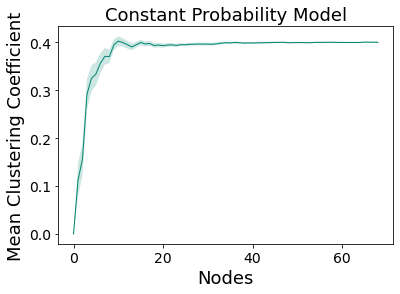

In [79]:
plot_curve(clust_coef_CP, curve_label = 'Clust. Coef.', curve_color = '#018571')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Mean Clustering Coefficient', fontsize = 18)
plt.title('Constant Probability Model', fontsize = 18)
plt.savefig('Figures/C/constant_probability_clust_coef.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


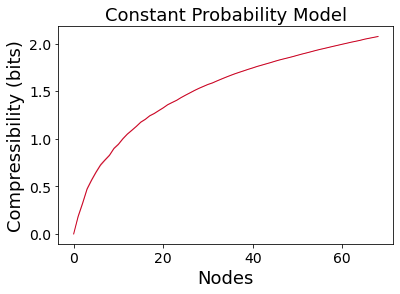

In [80]:
plot_curve(C_CP, curve_label = 'C', curve_color = '#ca0020')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility (bits)', fontsize = 18)
plt.title('Constant Probability Model', fontsize = 18)
plt.savefig('Figures/C/constant_probability_C.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


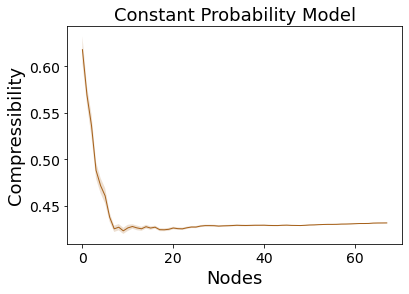

In [81]:
plot_curve(C_norm_CP, curve_label = '$C_{norm}$', curve_color = '#a6611a')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility', fontsize = 18)
plt.title('Constant Probability Model', fontsize = 18)
plt.savefig('Figures/C/constant_probability_C_norm.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


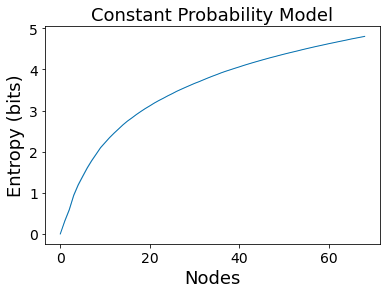

In [82]:
plot_curve(entropy_CP, curve_label = 'H', curve_color = '#0571b0')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Entropy (bits)', fontsize = 18)
plt.title('Constant Probability Model', fontsize = 18)
plt.savefig('Figures/C/constant_probability_entropy.pdf', transparent = True, bbox_inches = 'tight')

## Proportional Probability Model

In [83]:
clust_coef_PP = data_dict['clust_coef_PP']
C_PP = data_dict['C_PP']
C_norm_PP = data_dict['C_norm_PP']
entropy_PP = data_dict['entropy_PP']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


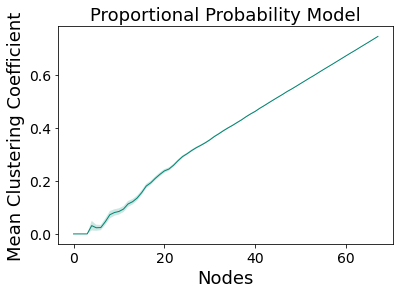

In [84]:
plot_curve(clust_coef_PP, curve_label = 'Clust. Coef.', curve_color = '#018571')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Mean Clustering Coefficient', fontsize = 18)
plt.title('Proportional Probability Model', fontsize = 18)
plt.savefig('Figures/C/proportional_probability_clust_coef.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


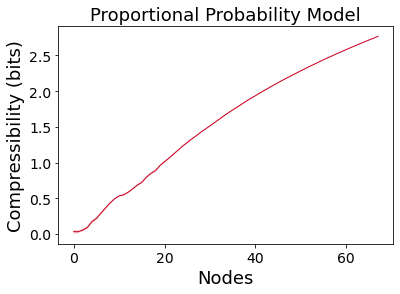

In [85]:
plot_curve(C_PP, curve_label = 'C', curve_color = '#ca0020')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility (bits)', fontsize = 18)
plt.title('Proportional Probability Model', fontsize = 18)
plt.savefig('Figures/C/proportional_probability_C.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


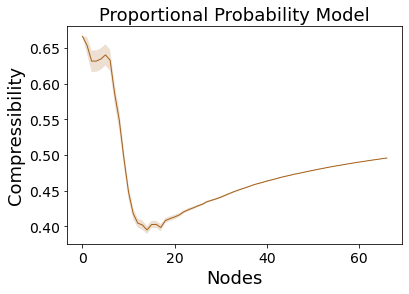

In [86]:
plot_curve(C_norm_PP, curve_label = 'C', curve_color = '#a6611a')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility', fontsize = 18)
plt.title('Proportional Probability Model', fontsize = 18)
plt.savefig('Figures/C/proportional_probability_C_norm.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


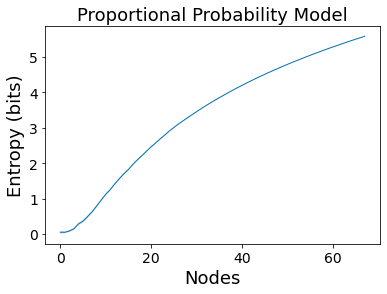

In [87]:
plot_curve(entropy_PP, curve_label = 'H', curve_color = '#0571b0')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Entropy (bits)', fontsize = 18)
plt.title('Proportional Probability Model', fontsize = 18)
plt.savefig('Figures/C/proportional_probability_entropy.pdf', transparent = True, bbox_inches = 'tight')

## Preferential Attachment Model

In [88]:
clust_coef_PA = data_dict['clust_coef_PA']
C_PA = data_dict['C_PA']
C_norm_PA = data_dict['C_norm_PA']
entropy_PA = data_dict['entropy_PA']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


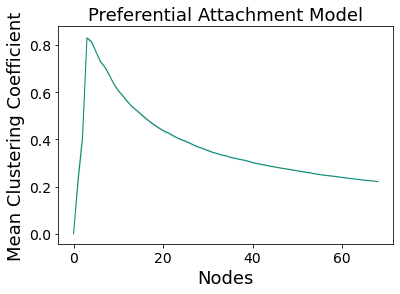

In [89]:
plot_curve(clust_coef_PA, curve_label = 'Clust. Coef.', curve_color = '#018571')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Mean Clustering Coefficient', fontsize = 18)
plt.title('Preferential Attachment Model', fontsize = 18)
plt.savefig('Figures/C/preferential_attachment_clust_coef.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


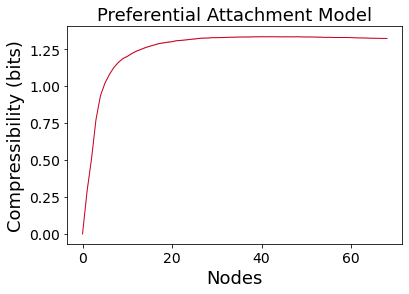

In [90]:
plot_curve(C_PA, curve_label = 'C', curve_color = '#ca0020')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility (bits)', fontsize = 18)
plt.title('Preferential Attachment Model', fontsize = 18)
plt.savefig('Figures/C/preferential_attachment_C.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


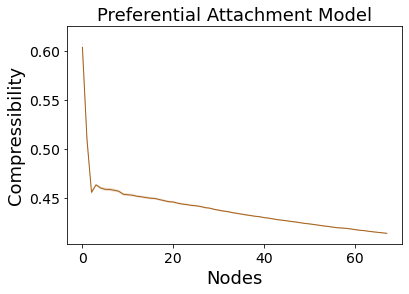

In [91]:
plot_curve(C_norm_PA, curve_label = 'C', curve_color = '#a6611a')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Compressibility', fontsize = 18)
plt.title('Preferential Attachment Model', fontsize = 18)
plt.savefig('Figures/C/preferential_attachment_C_norm.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


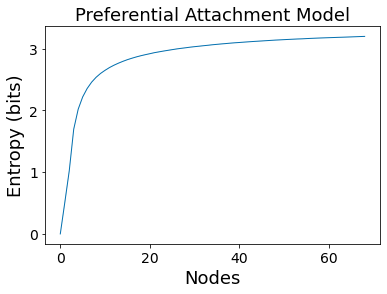

In [92]:
plot_curve(entropy_PA, curve_label = 'H', curve_color = '#0571b0')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('Entropy (bits)', fontsize = 18)
plt.title('Preferential Attachment Model', fontsize = 18)
plt.savefig('Figures/C/preferential_attachment_entropy.pdf', transparent = True, bbox_inches = 'tight')